As the saying goes, "A rising tide lifts all boat". As we saw with the recent AI boom, across many sectors, throughout the chipmaking supply chain and further beyond, we saw the explosion of corporate valuations in tech and tech-adjacent industries, fueling unprecedented growth in global equity markets.

A proxy with which we use to track the direct returns of the AI boom is the iShares Future AI & Tech ETF [NYSE:ARTY](ishares.com/us/products/297905/ishares-future-ai-tech-etf) which is based upon the [Morningstar Global Artificial Intelligence Select](indexes.morningstar.com/indexes/details/morningstar-global-artificial-intelligence-select-FS0000IRMK)

It is noteworthy that many of the top holdings in this basket mainly comprise three categories, the chipmakers, the chip integrators, and the chip users. Thus, a reasonable hypothesis is that there exists a great degree of cointegrability between the top holdings, giving rise to opportunities for pair trading.

We select the top 9 holdings as of December 2025, as our benchmark for holding compositions.

## Imports and Setup

Core libraries are as follows:
- Numpy, Pandas: Data Wrangling
- Matplotlib, Seaborn: Data Visualisation
- yfinance: data source
- statsmodels, arch: tests, models, and diagnostics

In [1]:
import subprocess

try:
  import arch
except ImportError:
  print("Installing arch...")
  subprocess.check_call(['pip', 'install', 'arch'])

# !pip install arch

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

import yfinance as yf

import warnings

from arch.unitroot import ADF,KPSS
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.ardl import UECM
from statsmodels.stats.stattools import durbin_watson

# from statsmodels.stats.diagnostic import acorr_ljungbox


In [3]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Step 1 - Configure and prepare data
We extract the top 9 holdings of ARTY as of 31st December 2025, with our test range from 1st Jan 2021 to 31st Dec 2025. Returns are calculated based on Day-on-Day adjusted closing prices, provided for by yfinance API.

In [4]:


# Define the AI Supply Chain
# We swapped "2330" with the ADR variant "NYSE:TSM"
# Naver and SK Hynix are substituted for the next biggest two holdings of ARTY, MSFT and SMCI, for a lack of available data
# Coreweave (NYSE: CRVW) is omitted as it is a recent IPO and do not have enough data to cover our sample timeframe

aislop_tickers = [
    'MU','NVDA','TSM','AMD',
    'MRVL','ORCL','AVGO','SMCI',
    'MSFT'
]

START_DATE = '2021-01-01'
END_DATE = '2025-12-31'

aislop_data = yf.download(aislop_tickers, start=START_DATE, end=END_DATE,auto_adjust=True)
df = aislop_data['Close']
df.head(),df.tail()


[*********************100%***********************]  9 of 9 completed


(Ticker            AMD       AVGO       MRVL        MSFT         MU       NVDA  \
 Date                                                                            
 2021-01-04  92.300003  38.253105  45.389660  208.882233  72.250366  13.076727   
 2021-01-05  92.769997  38.512192  46.663815  209.083679  75.382339  13.367158   
 2021-01-06  90.330002  38.274693  45.585686  203.662308  75.235992  12.579124   
 2021-01-07  95.160004  39.887695  48.045799  209.457916  77.187386  13.306580   
 2021-01-08  94.580002  40.090103  48.104607  210.734131  75.538429  13.239520   
 
 Ticker           ORCL   SMCI         TSM  
 Date                                      
 2021-01-04  59.305763  3.105  102.714417  
 2021-01-05  58.570831  3.116  103.698341  
 2021-01-06  58.430759  3.189  106.309891  
 2021-01-07  58.897686  3.219  111.661690  
 2021-01-08  59.187183  3.188  109.142105  ,
 Ticker             AMD        AVGO       MRVL        MSFT          MU  \
 Date                                    

In [5]:
for col in df.columns:
  print(f"{col}, Na: {df[col].isna().sum()} Null: {df[col].isnull().sum()} ")


AMD, Na: 0 Null: 0 
AVGO, Na: 0 Null: 0 
MRVL, Na: 0 Null: 0 
MSFT, Na: 0 Null: 0 
MU, Na: 0 Null: 0 
NVDA, Na: 0 Null: 0 
ORCL, Na: 0 Null: 0 
SMCI, Na: 0 Null: 0 
TSM, Na: 0 Null: 0 


## Step 2a - Stationarity of Adjusted Price

We examine the behaviour of the time-series of adjusted prices.

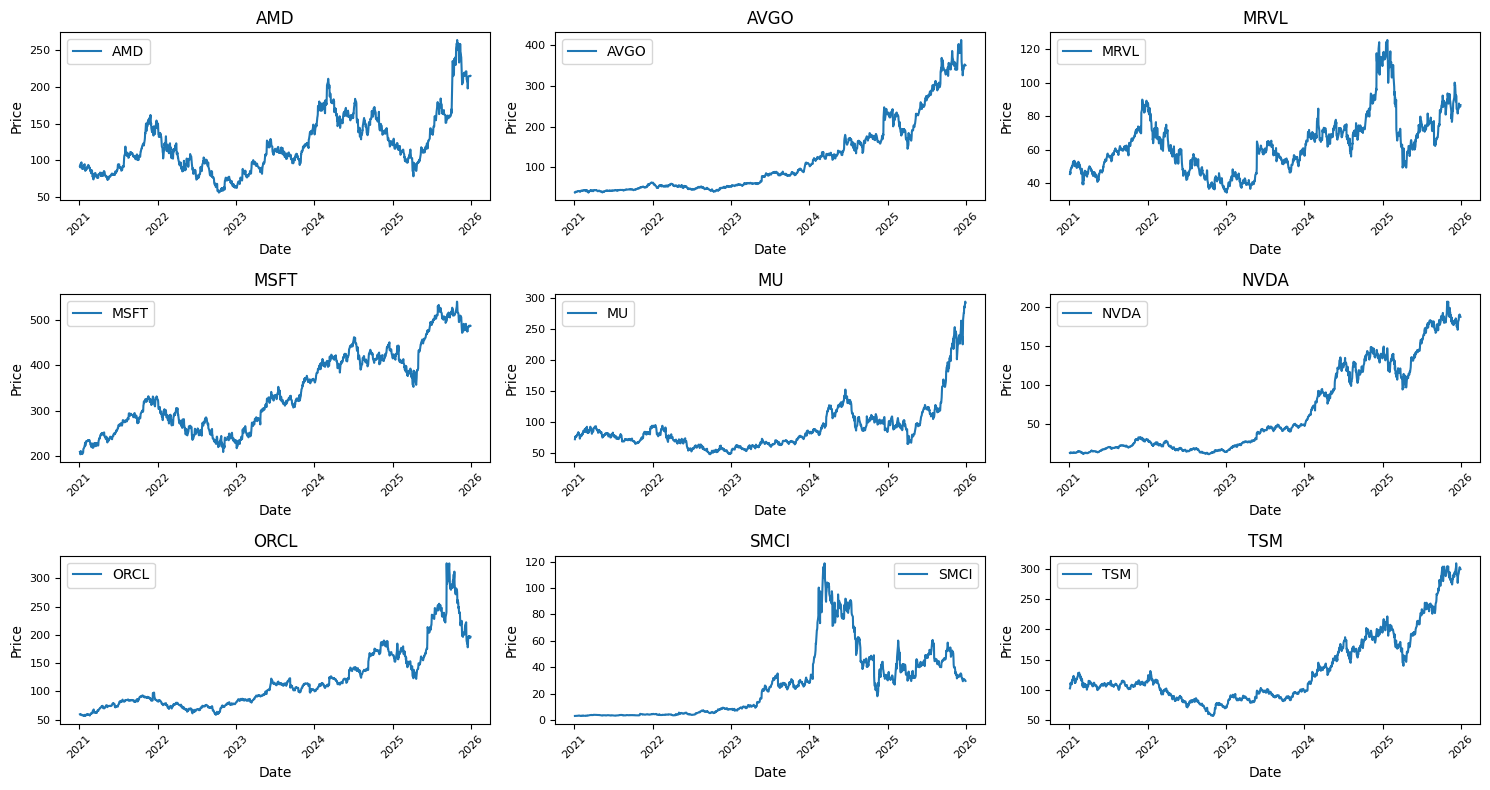

In [6]:
# We investigate the actual prices of the stocks over the timeframe

fig, axs = plt.subplots(3,3, figsize=(15, 8))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

idx = 0
for ticker in df.columns:
    row = idx // 3
    col = idx % 3
    sns.lineplot(
        data=df[ticker],
        ax=axs[row, col],
        label=ticker
    )
    axs[row, col].set_title(ticker)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')

    # This is to clean up the x-axis and show by year
    axs[row, col].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Smaller and More Readable Fonts (Hopefully)
    axs[row, col].tick_params(axis='x', labelsize=8, rotation=45)
    axs[row, col].tick_params(axis='y', labelsize=8)


    idx += 1

plt.tight_layout()
plt.show()



Purely from the adjusted closing prices, we can see that to a certain extent, that a majority of tickers have similar movement in prices.

Whereas different market segments such as the chipmaker representative, SMCI, behaves as an anomaly to the trend.

For a complete analysis, we do a simple Augmented Dicky-Fuller (ADF) Test on all the time series to determine if they are stationary.

The null hypothesis of ADF is constructed as such:

$H_{0}$: The time series has a unit root.

$H_{1}$: The time series does not have a unit root.



In [7]:
df_unittest_res = []
for ticker in df.columns:

    # ADF test
    adf_result = ADF(df[ticker], trend="n", method="bic")

    df_unittest_res.append({
        'ticker': ticker,
        'adf_stat': adf_result.stat,
        'adf_pval': adf_result.pvalue,
        'adf_lags': adf_result.lags,
        'adf_stationary': adf_result.pvalue < 0.05,
    })

# Convert to DataFrame
results_df = pd.DataFrame(df_unittest_res)


results_df

,ticker,adf_stat,adf_pval,adf_lags,adf_stationary
0,AMD,0.393451,0.799260,0,False
1,AVGO,2.269153,0.995713,4,False
2,MRVL,-0.209491,0.610388,0,False
3,MSFT,1.215530,0.942128,0,False
4,MU,3.120451,0.999901,4,False
5,NVDA,1.670517,0.977326,2,False
6,ORCL,0.330087,0.782917,0,False
7,SMCI,-0.841368,0.353199,3,False
8,TSM,2.031405,0.991072,1,False


As p-value for all the tickers are greater than 0.05, and by a large margin, we thus accept the null hypothesis that all time-series of ticker prices has a unit root and are thus non-stationary.

## Step 2b. Stationarity of Returns

The daily return can be calculated as such

$$
Returns,\space r = \frac{P_t - P_{t-1}}{P_{t-1}} \\
Thus, log(r) = log{\frac{P_t}{P_{t-1}}} = ln(P_t) - ln(P_{t-1})\\
$$

We thus investigate the first difference of the log of prices as a measure of the daily returns.

In [8]:
# This gets the log of prices
df_log = np.log(df)
df_log.head()

Ticker,AMD,AVGO,MRVL,MSFT,MU,NVDA,ORCL,SMCI,TSM
Date,,,,,,,,,
2021-01-04,4.525044,3.644225,3.815284,5.341771,4.280137,2.570834,4.082706,1.133014,4.631952
2021-01-05,4.530123,3.650975,3.842969,5.342735,4.322573,2.592801,4.070237,1.136550,4.641486
2021-01-06,4.503470,3.644789,3.819594,5.316463,4.320630,2.532039,4.067842,1.159707,4.666358
2021-01-07,4.555560,3.686068,3.872155,5.344523,4.346236,2.588259,4.075802,1.169071,4.715474
2021-01-08,4.549446,3.691129,3.873378,5.350597,4.324642,2.583206,4.080705,1.159394,4.692651


In [9]:
df_r = df_log.diff().dropna()
df_r.head()

Ticker,AMD,AVGO,MRVL,MSFT,MU,NVDA,ORCL,SMCI,TSM
Date,,,,,,,,,
2021-01-05,0.005079,0.006750,0.027685,0.000964,0.042436,0.021967,-0.012470,0.003536,0.009534
2021-01-06,-0.026654,-0.006186,-0.023375,-0.026271,-0.001943,-0.060762,-0.002394,0.023157,0.024872
2021-01-07,0.052090,0.041279,0.052561,0.028060,0.025606,0.056220,0.007959,0.009363,0.049115
2021-01-08,-0.006114,0.005062,0.001223,0.006074,-0.021595,-0.005052,0.004903,-0.009677,-0.022823
2021-01-11,0.027839,0.000269,0.023360,-0.009746,0.016017,0.025635,-0.005538,0.006877,0.032412


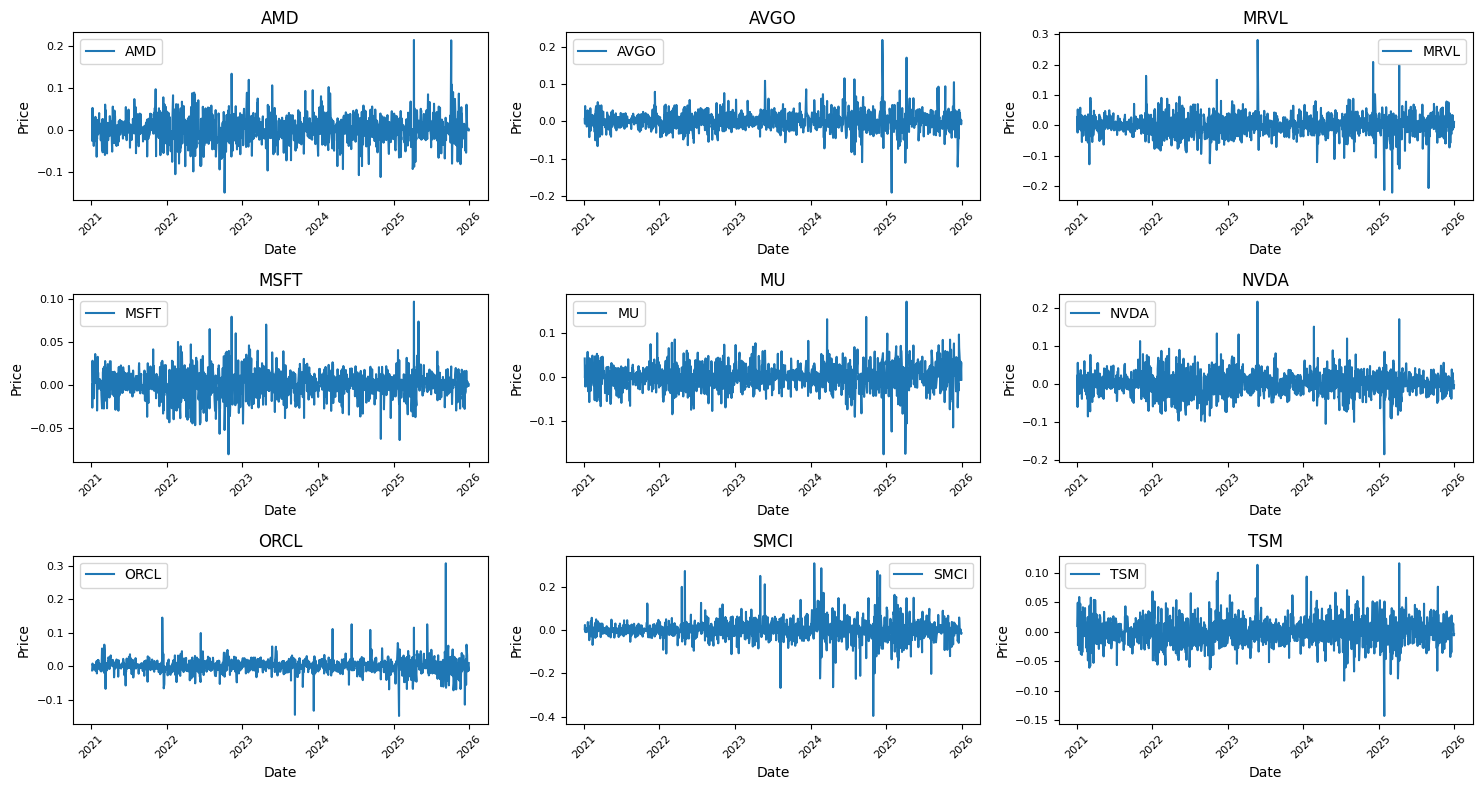

In [10]:
# We now consider the time-series of the log returns

fig, axs = plt.subplots(3, 3, figsize=(15, 8))
idx = 0
for ticker in df_r.columns:
    row = idx // 3
    col = idx % 3
    sns.lineplot(
        data=df_r[ticker],
        ax=axs[row, col],
        label=ticker
    )
    axs[row, col].set_title(ticker)
    axs[row, col].set_xlabel('Date')
    axs[row, col].set_ylabel('Price')

    # X-axis cleanup
    axs[row, col].xaxis.set_major_locator(mdates.YearLocator())
    axs[row, col].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Smaller Fonts
    axs[row, col].tick_params(axis='x', labelsize=8, rotation=45)
    axs[row, col].tick_params(axis='y', labelsize=8)
    idx += 1

plt.tight_layout()
plt.show()


On first glance, it appears that the first-differenced daily returns is fairly stationary. We plot the Autocorrelation Function (ACF) and Partial Autocorrelation Functions (PACF) to test for additional serial correlations.

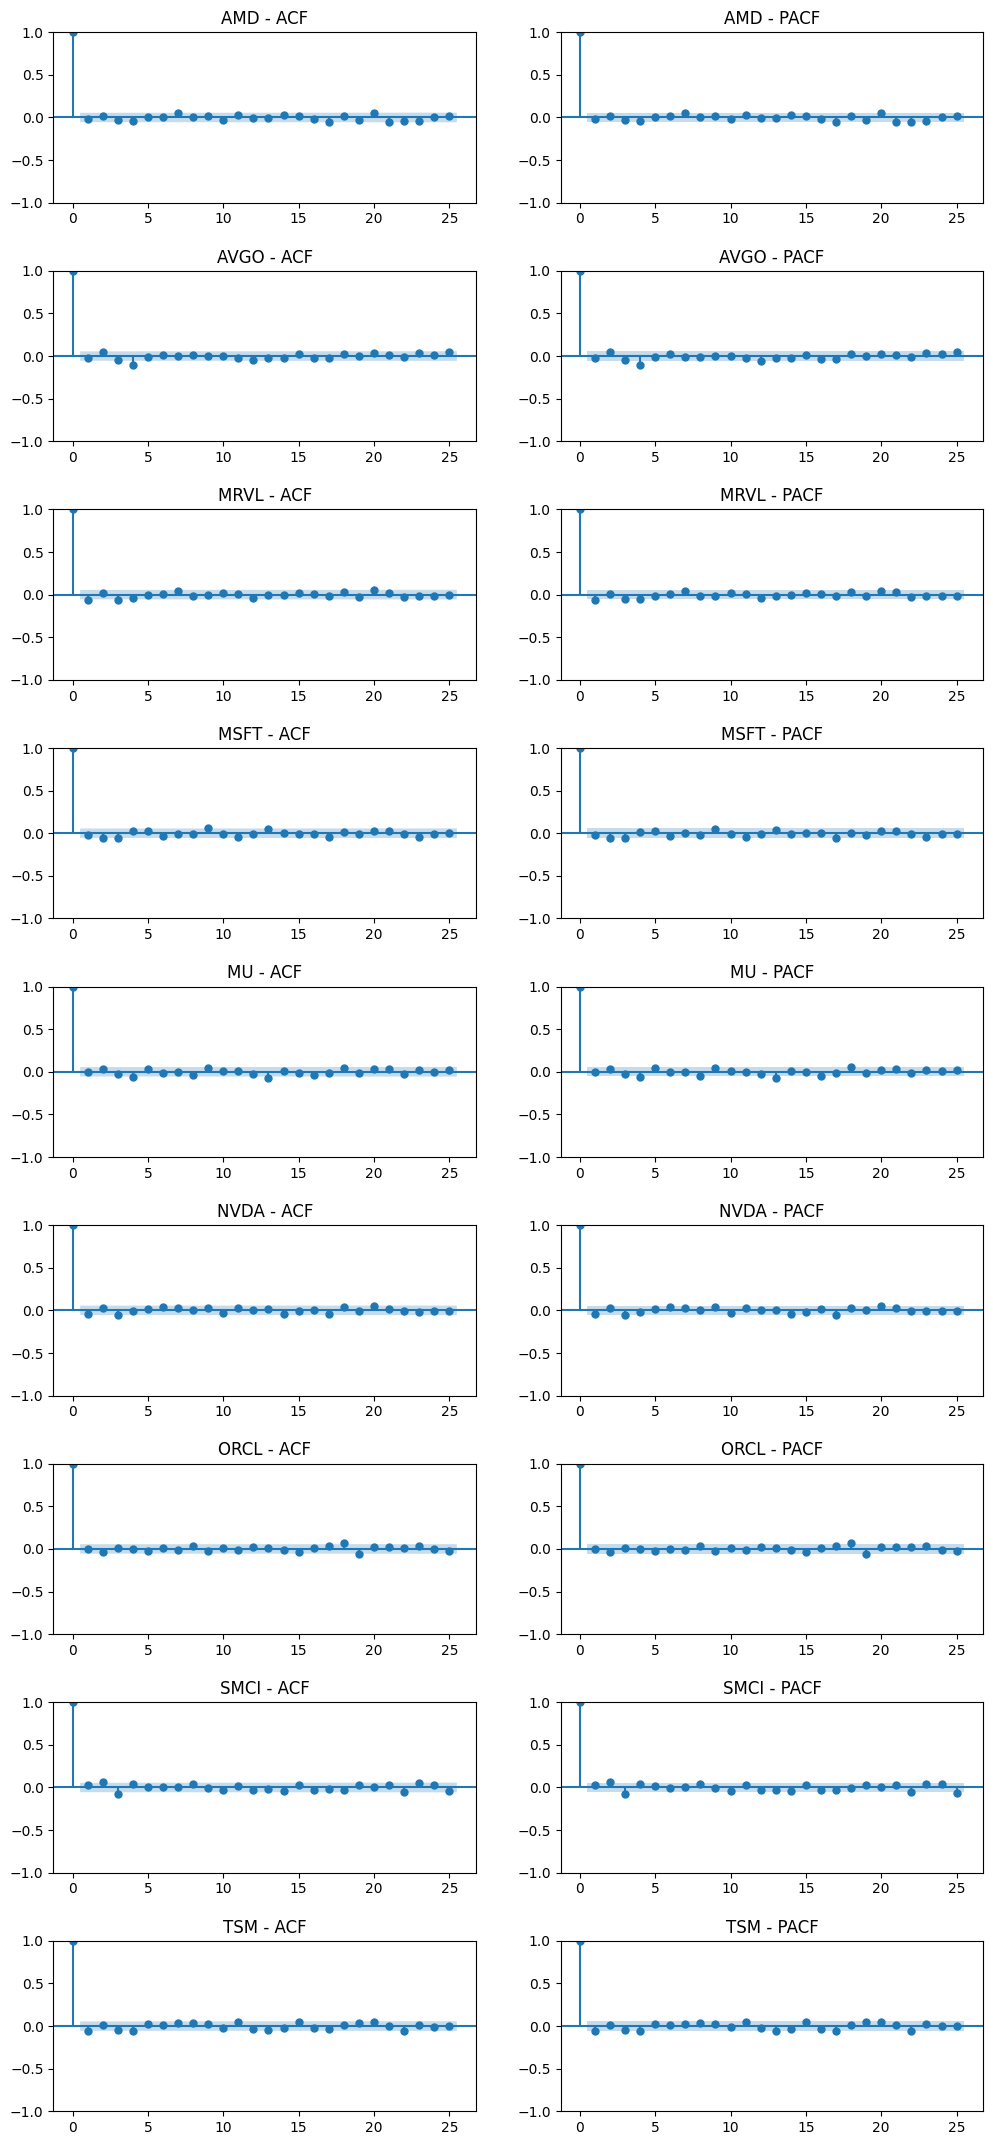

In [11]:


max_lags = 25
fig,axes = plt.subplots(9, 2, figsize=(12, 3 * 9))
row = 0
for col in df_r.columns:
  plot_acf(df_r[col], lags=max_lags, ax=axes[row, 0], title=f"{col} - ACF")
  plot_pacf(df_r[col], lags=max_lags, ax=axes[row, 1], title=f"{col} - PACF")
  row += 1

fig.subplots_adjust(
    hspace=0.4)
plt.show()


All the assets show little evidence of serial correlation beyond lag 1 as the ACF and PACF of the first differenced series falls within error bands. We next test for stationarity amongst the assets.


Augmented Dicky-Fuller (ADF) test and Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test is then used to test for stationarity in the first differenced series.

The null hypothesis for ADF is explained earlier and remains the same, although it works over a different time-series.

KPSS is run in both the constant variant and trend variant.

The null hypothesis for the constant form of KPSS is as such:

$H_{0}$: The time series is stationary about a constant.

$H_{1}$: The time series is non-stationary about a constant.

The null hypothesis for the trend form of KPSS is as such:

$H_{0}$: The time series is stationary about a trend.

$H_{1}$: The time series is non-stationary about a trend.

In general, KPSS in its trend variant is a weaker form of KPSS in its constant variant.


In [12]:
df_r_unittest_result = []
for ticker in df.columns:

    print(ticker)
    # ADF test
    adf_result = ADF(df_r[ticker], trend="n", method="bic")

    # KPSS test
    kpss_result_c = KPSS(df_r[ticker],trend='c')
    kpss_result_ct = KPSS(df_r[ticker],trend='ct')

    df_r_unittest_result.append({
        'ticker': ticker,
        'adf_stat': adf_result.stat,
        'adf_pval': adf_result.pvalue,
        'adf_lags': adf_result.lags,
        'adf_stationary': adf_result.pvalue < 0.05,
        'kpss_c_stat': kpss_result_c.stat,
        'kpss_c_crit_5%': kpss_result_c.critical_values['5%'],
        'kpss_c_pval': kpss_result_c.pvalue,
        'kpss_c_lags': kpss_result_c.lags,
        'kpss_c_stationary': kpss_result_c.pvalue > 0.05,
        'kpss_ct_stat': kpss_result_ct.stat,
        'kpss_ct_crit_5%': kpss_result_c.critical_values['5%'],
        'kpss_ct_pval': kpss_result_ct.pvalue,
        'kpss_ct_lags': kpss_result_ct.lags,
        'kpss_ct_stationary': kpss_result_ct.pvalue > 0.05,
    })

# Convert to DataFrame
results_df = pd.DataFrame(df_r_unittest_result)


results_df

AMD
AVGO
MRVL
MSFT
MU
NVDA
ORCL
SMCI
TSM


,ticker,adf_stat,adf_pval,adf_lags,adf_stationary,kpss_c_stat,kpss_c_crit_5%,kpss_c_pval,kpss_c_lags,kpss_c_stationary,kpss_ct_stat,kpss_ct_crit_5%,kpss_ct_pval,kpss_ct_lags,kpss_ct_stationary
0,AMD,-36.154024,0.0,0,True,0.083136,0.4614,0.674386,7,True,0.048282,0.4614,0.598734,7,True
1,AVGO,-36.179318,0.0,0,True,0.141708,0.4614,0.416449,14,True,0.029241,0.4614,0.883043,14,True
2,MRVL,-37.843476,0.0,0,True,0.041393,0.4614,0.926089,13,True,0.039439,0.4614,0.730693,13,True
3,MSFT,-35.881448,0.0,0,True,0.058575,0.4614,0.823474,8,True,0.059578,0.4614,0.452973,8,True
4,MU,-35.496964,0.0,0,True,0.363316,0.4614,0.090623,8,True,0.070070,0.4614,0.346641,9,True
5,NVDA,-36.931130,0.0,0,True,0.108124,0.4614,0.547166,7,True,0.090725,0.4614,0.204769,7,True
6,ORCL,-35.392652,0.0,0,True,0.043468,0.4614,0.915170,2,True,0.043417,0.4614,0.669746,2,True
7,SMCI,-34.467326,0.0,0,True,0.180377,0.4614,0.309478,3,True,0.105515,0.4614,0.140696,3,True
8,TSM,-37.429241,0.0,0,True,0.323283,0.4614,0.116759,12,True,0.043184,0.4614,0.673246,13,True


Since the test statistic value for all the tickers is below the p-value at 5% significance for the ADF test, we shall reject the null hypothesis that there exist a unit root for first differenced time-series of 16 tickers, and conclude that they are stationary. Furthermore with our KPSS test statistic value is smaller than the p-value at 5% for KPSS constant test and KPSS constant with test trend, we also accept the null hypothesis of KPSS that the price trends are stationary about a constant.



We expect to expand our analysis to cover the cointegrability of the different equities that make up our basket. For which, homoskedascity is a consideration. We test if each of the first-differenced time-series is homoskedastic with Engle's ARCH test.

Our null hypothesis is constructed as such:

$H_0$ : The time series has evidence of ARCH(1)

$H_1$ : The time series has no evidence for ARCH(1)




In [13]:
arch_res = []

for col in df_r.columns:
    stat, pval, _, _ = het_arch(df_r[col], nlags=5)
    arch_res.append({
        'ticker': col,
        'arch_stat': stat,
        'arch_pval': pval,
        'arch_stationary': pval > 0.05
    })
arch_res_df = pd.DataFrame(arch_res)
arch_res_df

,ticker,arch_stat,arch_pval,arch_stationary
0,AMD,18.932409,1.978657e-03,False
1,AVGO,37.825415,4.090525e-07,False
2,MRVL,9.355986,9.568013e-02,True
3,MSFT,18.125061,2.793684e-03,False
4,MU,82.987497,1.988085e-16,False
5,NVDA,11.267616,4.632468e-02,False
6,ORCL,3.475716,6.270652e-01,True
7,SMCI,31.155636,8.727219e-06,False
8,TSM,20.973264,8.195355e-04,False


MRVL and ORCL has a p-value larger than 0.05, thus we accept the null hypotthesis that there is no evidence for ARCH(1). For the rest, we reject the null hypothesis of no ARCH(1) condition and conclude that there is evidence of ARCH(1) behaviour.

## Step 3. 2-variable ECM

The two largest GPU manufacturers in the world are NVIDIA and AMD respectively (insert source here). The extremely high barrier to entry, infrastructure, and R&D costs required to compete in this space lends itself to a natural duopoly. We thus reasoned that there exists a natural equillibrium in this space and thus a cointegrated pair between the two is a plausible outcome.


### 3.1 Phillips-Ouliaris Test
We check for unit root of residuals using PO test. The null hypothesis are described as such:

$H_0$ : The residuals of the two time-series have a unit root and thus the two time series are not cointegrated.

$H_1$ : The residuals of the two time-series exhibit stationarity and thus the two time series are cointegrated.

<Axes: xlabel='Date', ylabel='NVDA'>

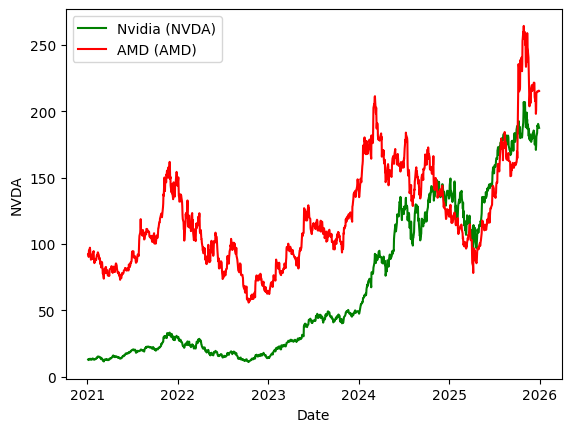

In [14]:
sns.lineplot(df['NVDA'], c='g',label='Nvidia (NVDA)')
sns.lineplot(df['AMD'], c='r',label='AMD (AMD)')

The first test to perform is the Engle-Granger 2-step test for Cointegration



In [15]:
from arch.unitroot.cointegration import phillips_ouliaris

phillips_ouliaris(
    y=df['AMD'],
    x=df['NVDA'],
    trend="c", test_type="Za", kernel="bartlett"
)

Test Statistic,-12.519
P-value,0.226
Kernel,Bartlett
Bandwidth,11.346


The test statistic of this test at -12.51 is well above the critical values of -20.52 at 5% significance and the P-value is at 0.496, we therefore accept the null hypothesis that NVDA and AMD are not cointegrated.



Another set of firms worth exploring for individual cointegration is that of NVDA and AVGO. Both have strong incumbent advantage and high barriers to entry in their fields, in computing and hardware respectively.

<Axes: xlabel='Date', ylabel='NVDA'>

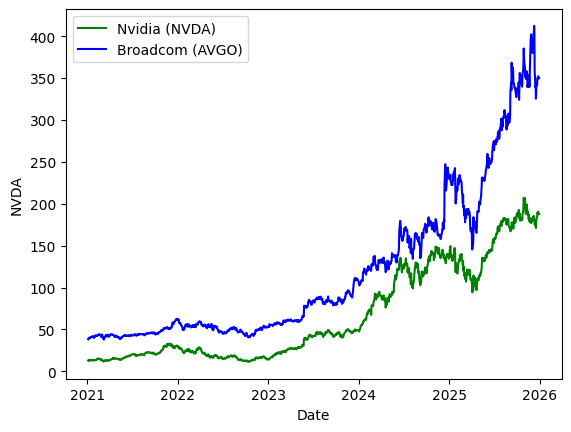

In [16]:
sns.lineplot(df['NVDA'], c='g',label='Nvidia (NVDA)')
sns.lineplot(df['AVGO'], c='b',label='Broadcom (AVGO)')

In [17]:
phillips_ouliaris(
    y=df['AVGO'],
    x=df['NVDA'],
    trend="c", test_type="Za", kernel="bartlett"
)

Test Statistic,-18.843
P-value,0.071
Kernel,Bartlett
Bandwidth,10.791


The p-value is 0.071 which weakly rejects the null hypothesis that NVDA and AVGO are not cointegrated. We can still attempt to construct a Bivariate ECM model based on AVGO-NVDA pair.

### Step 3.2 Determing Lag

We then apply Vector Autoregressive Model (VAR) for different values of lag to select for the best parameters, using AIC and BIC.

In [18]:
var_model = VAR(df[['NVDA','AVGO']])
x = var_model.select_order(maxlags=12, trend="c")
x.summary()

c:\Users\00492\Documents\Codebase\Quant\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,14.47,14.48,1.930e+06,14.48
1,4.585,4.610,98.00,4.594
2,4.557,4.598,95.27,4.572
3,4.551,4.609,94.73,4.573
4,4.548,4.622,94.45,4.576
5,4.498,4.588*,89.80,4.532*
6,4.496*,4.603,89.62*,4.536
7,4.499,4.623,89.90,4.545
8,4.504,4.644,90.37,4.557
9,4.501,4.658,90.11,4.560


### Step 3.3 VAR Modelling

Based on our results, in AIC, the best lag to use is found in lag 6, with the smallest AIC at 4.496. In BIC, the best lag is found in lag 5 at 4.588.

We thus run the VAR(5) model to fit our NVDA-AVGO pair.

In [19]:
var_model_r = VAR(df_r[['NVDA','AVGO']])
var_results = var_model_r.fit(
    maxlags=5,
    trend="c",
    method='ols',
    verbose=True,
    ic='aic',
)
print(var_results.summary())

<statsmodels.tsa.vector_ar.var_model.LagOrderResults object. Selected orders are: AIC -> 4, BIC -> 0, FPE -> 4, HQIC ->  0>
Using 4 based on aic criterion
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Feb, 2026
Time:                     14:35:53
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.6039
Nobs:                     1249.00    HQIC:                  -14.6500
Log likelihood:           5639.78    FPE:                4.22190e-07
AIC:                     -14.6778    Det(Omega_mle):     4.16171e-07
--------------------------------------------------------------------
Results for equation NVDA
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.002351         0.000932            2.521           0.012
L1.NV

c:\Users\00492\Documents\Codebase\Quant\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


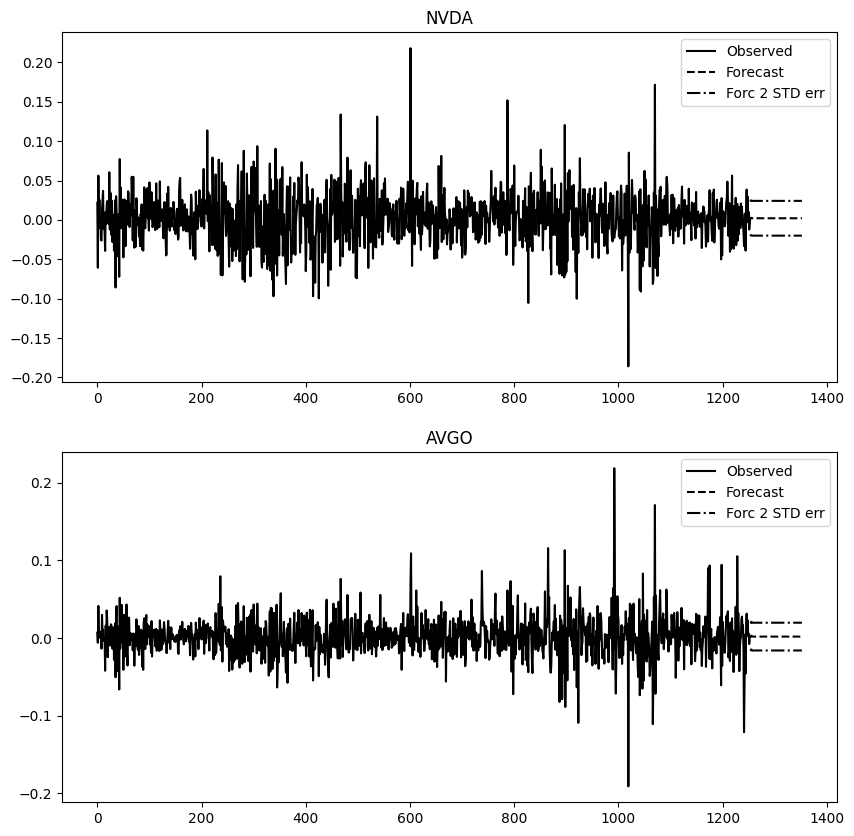

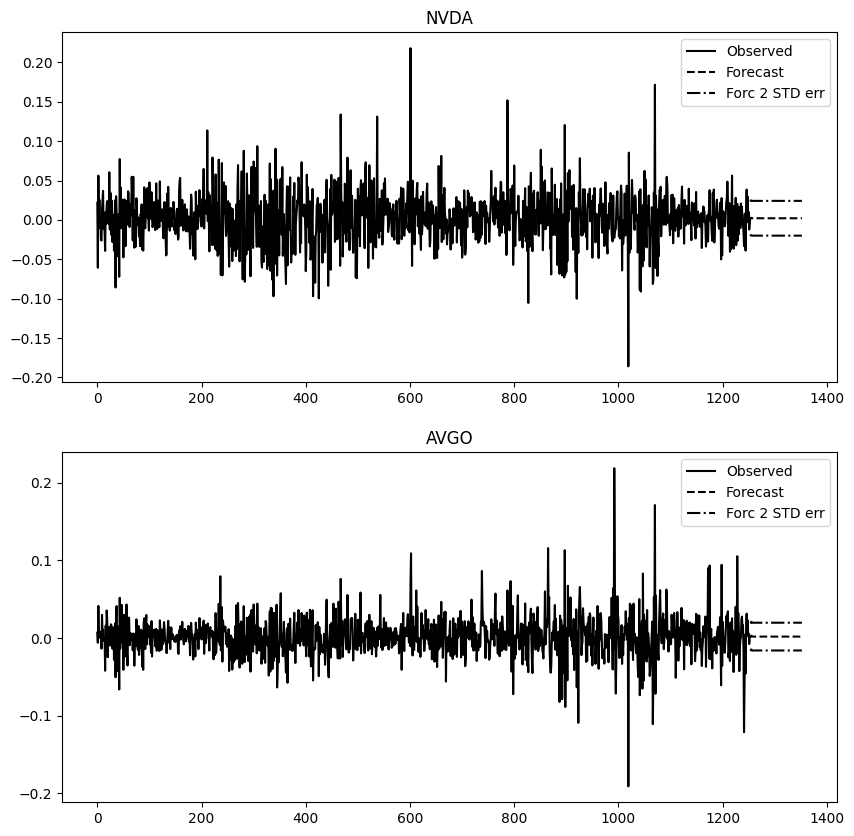

In [20]:
var_results.plot_forecast(steps=100, alpha=0.5, plot_stderr=True)

 From here on, we can use VAR to forecast the first difference for the next 50 time steps and estimate the resultant price of both tickers. We compare this against closing prices for the first week of 2026.

[*********************100%***********************]  2 of 2 completed


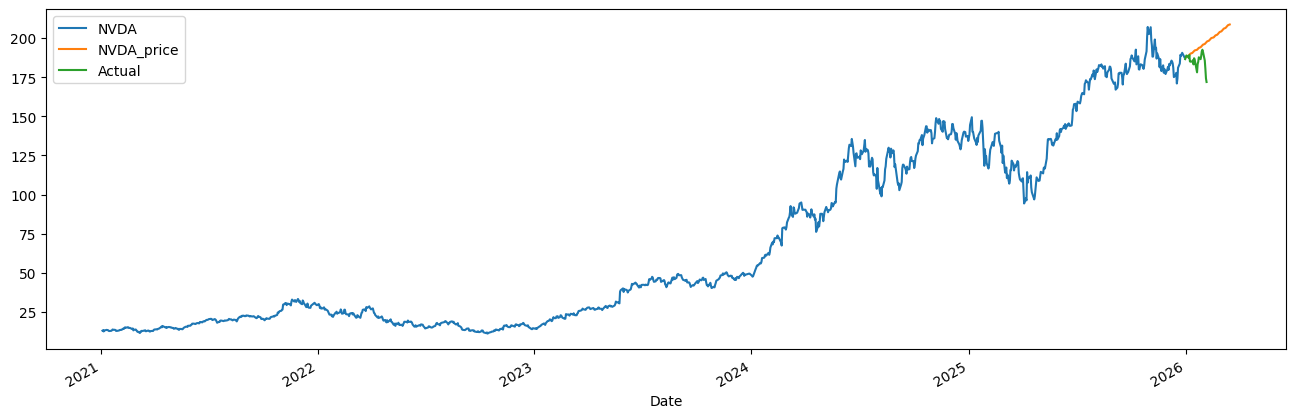

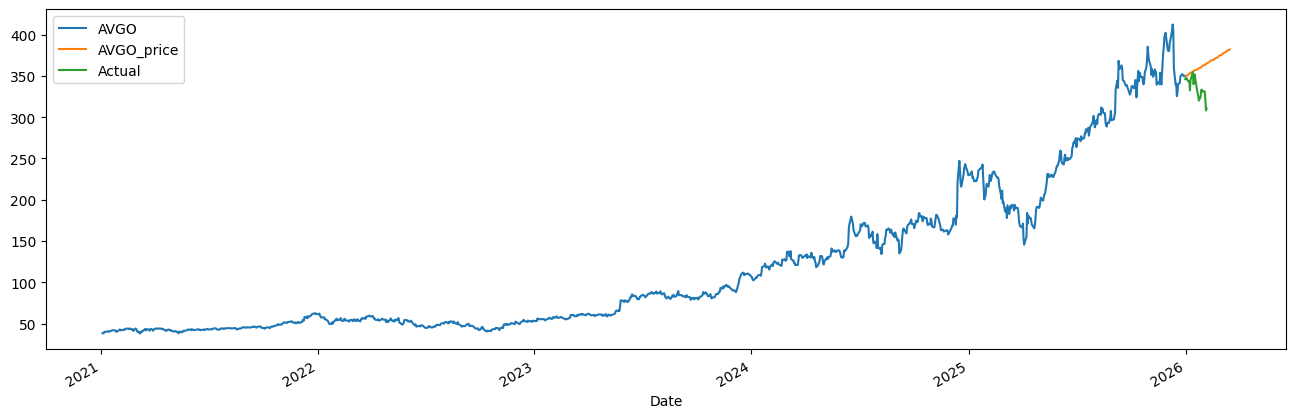

In [21]:
df_r_val = df_r[['NVDA','AVGO']].values[var_results.k_ar :]


var_pred = var_results.forecast(
    y=df_r_val,
    steps=50)

us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
idx = pd.date_range("2026-01-01", periods=50, freq=us_bd)
df_actual = yf.download(["NVDA","AVGO"], start=END_DATE, end=idx[-1],auto_adjust=True)['Close']

df_forecast = pd.DataFrame(
    data=var_pred, index=idx, columns=['NVDA1d','AVGO1d']
)

for col in ['NVDA','AVGO']:
  df_forecast[f"{col}_log"] = df_log[col].iloc[-1] + df_forecast[f"{col}1d"].cumsum()
  df_forecast[f"{col}_price"] = np.exp(df_forecast[f"{col}_log"])

  df[f"{col}"].plot(figsize=(16, 5), legend=True)
  df_forecast[f"{col}_price"].plot(legend=True)
  df_actual[f"{col}"].plot(legend=True, label="Actual")
  plt.show()


We note of this model as it has managed to stay within relatively close to the mean of the forecast as of this writing, by comparing how close the orange line is to the green.

In a typical pair trade, we would long the ticker if it is below the orange line, as it represents that it is undervalued compared to cointegrated pair, and short if it were above because it is overvalued compared to it's cointegrated pair.

### Step 3.4 ECM Pairwise Model

In this section, we apply cointegration technique of Error Correction Model to model possible mean reversion property of NVDA-AVGO pair. In earlier sections, we have determined that all the first difference of time-series are I(1), thus fulfilling the first test of Engle-Granger 2-step test. We also determined that there exists cointegration between NVDA and AVGO using PO test.

In [22]:
ecm_model = UECM(
    endog=df[['NVDA']],
    lags=5,
    exog=df[['AVGO']],
    order=1,
    trend="c",
).fit()
print(ecm_model.summary())

                              UECM Model Results                              
Dep. Variable:                 D.NVDA   No. Observations:                 1254
Model:                     UECM(5, 1)   Log Likelihood               -2668.568
Method:               Conditional MLE   S.D. of innovations             88.324
Date:                Fri, 06 Feb 2026   AIC                           5355.135
Time:                        14:35:57   BIC                           5401.306
Sample:                             5   HQIC                          5372.493
                                 1254                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0068      0.097      0.070      0.944      -0.183       0.197
NVDA.L1       -0.0083      0.004     -2.132      0.033      -0.016      -0.001
AVGO.L1        0.0052      0.002      2.130      0.0

c:\Users\00492\Documents\Codebase\Quant\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Since our $\lambda$, NVDA.L1 is -0.0083, which is between 0 and -1, we can therefore construct our ECM based on this set of parameters.

In [23]:
residuals = ecm_model.resid

dw_stat = durbin_watson(residuals)
dw_stat


np.float64(0.0007497233438778823)

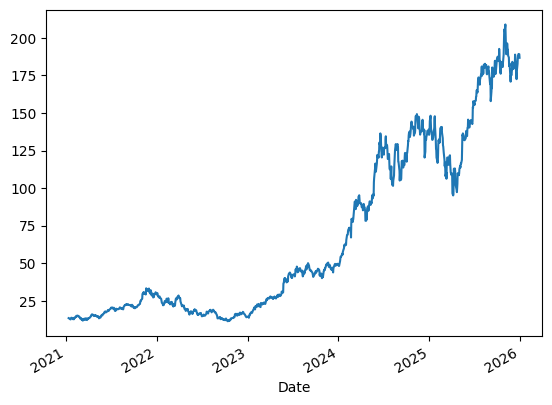

In [24]:
residuals.plot()
plt.show()

Our residuals do not pass Durbin-Watson's Test, meaning there is still inherent serial correlation.

## Step 4. Multivariable VECM

In [25]:
from statsmodels.tsa.api import VAR


model = VAR(df)
x = model.select_order(maxlags=15, trend="c")
x.summary()

c:\Users\00492\Documents\Codebase\Quant\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,52.69,52.73,7.655e+22,52.71
1,18.79,19.16*,1.447e+08,18.93*
2,18.72,19.43,1.352e+08,18.99
3,18.73,19.77,1.360e+08,19.12
4,18.71,20.09,1.339e+08,19.23
5,18.67,20.38,1.279e+08,19.31
6,18.66*,20.71,1.272e+08*,19.43
7,18.69,21.08,1.317e+08,19.59
8,18.72,21.43,1.347e+08,19.74
9,18.71,21.76,1.334e+08,19.85


We thus select lag 1 as it has the smallest BIC and the AIC is reasonably small
enough. We do this to avoid overfitting.

In [26]:
from statsmodels.tsa.vector_ar.vecm import VECM, coint_johansen
jtest = coint_johansen(df, det_order=0, k_ar_diff=1)
jtest.trace_stat


array([229.71614059, 162.58016454, 119.81349318,  79.03767097,
        47.60445401,  29.21027191,  17.04057891,   8.05034424,
         2.18214644])

In [27]:
pd.DataFrame(
    {
        "Test statistic": jtest.trace_stat,

        "Critical values (90%)": jtest.trace_stat_crit_vals[:, 0],
        "Critical values (95%)": jtest.trace_stat_crit_vals[:, 1],
        "Critical values (99%)": jtest.trace_stat_crit_vals[:, 2],
    },
    index=[f"rank<={i}" for i in range(9)],
)

,Test statistic,Critical values (90%),Critical values (95%),Critical values (99%)
rank<=0,229.716141,190.8714,197.3772,210.0366
rank<=1,162.580165,153.6341,159.5290,171.0905
rank<=2,119.813493,120.3673,125.6185,135.9825
rank<=3,79.037671,91.1090,95.7542,104.9637
rank<=4,47.604454,65.8202,69.8189,77.8202
rank<=5,29.210272,44.4929,47.8545,54.6815
rank<=6,17.040579,27.0669,29.7961,35.4628
rank<=7,8.050344,13.4294,15.4943,19.9349
rank<=8,2.182146,2.7055,3.8415,6.6349


Based on this result, at 95% critical value, we reject the null hypothesis for rank 0 and rank 1. Thus there exists a linear combination of time-series that is stationary.

In [28]:
vecm_model = VECM(endog=df, k_ar_diff=2, deterministic="ci").fit()
print(vecm_model.summary())

c:\Users\00492\Documents\Codebase\Quant\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Det. terms outside the coint. relation & lagged endog. parameters for equation AMD
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
L1.AMD         0.0015      0.038      0.039      0.969      -0.074       0.077
L1.AVGO       -0.0431      0.038     -1.142      0.253      -0.117       0.031
L1.MRVL        0.0294      0.066      0.448      0.654      -0.099       0.158
L1.MSFT        0.0320      0.028      1.131      0.258      -0.023       0.087
L1.MU         -0.0128      0.049     -0.261      0.794      -0.109       0.084
L1.NVDA       -0.0518      0.073     -0.714      0.475      -0.194       0.090
L1.ORCL       -0.0363      0.033     -1.086      0.277      -0.102       0.029
L1.SMCI       -0.0049      0.058     -0.084      0.933      -0.119       0.110
L1.TSM         0.0281      0.056      0.503      0.615      -0.081       0.137
L2.AMD        -0.0304      0.038     -0.798     

This relationship is thus described as:

$$
Long + Short + 151 = 0 \\
Whereby, \\
Long = 1.00 AMD + 1.05 AVGO + 1.40 MRVL + 0.54 ORCL + 0.9 SMCI\\
Short = 1.35 MSFT + 0.72 TSM + 0.39 NVDA
$$

In a typical pair trading scenario, with this subindustry basket, when the basket (Long + Short + 151) is above 0, the basket is overvalued and should be shorted. Conversely the reverse is true, if the basket is undervalued, long the basket.

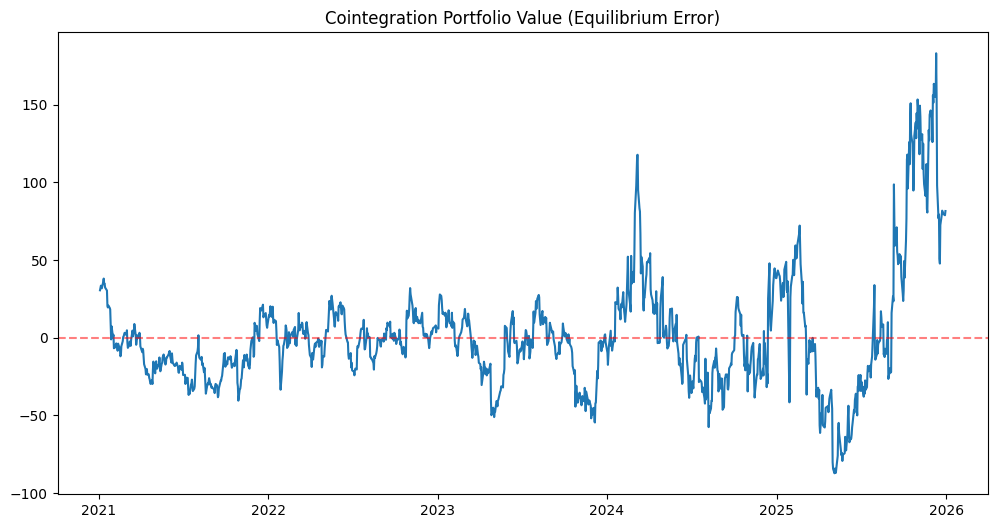

In [29]:
beta = vecm_model.beta[:, 0]

df_vecm_res = pd.DataFrame(index=df.index)
df_vecm_res['LS'] = 0

for i, col in enumerate(df.columns):
    df_vecm_res['LS'] += beta[i] * df[col]

df_vecm_res['LS'] += 151.3609  # Pull it back to zero

plt.figure(figsize=(12, 6))
plt.plot(df_vecm_res['LS'])
plt.title('Cointegration Portfolio Value (Equilibrium Error)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)  # Equilibrium
plt.show()


We should thus short the basket ...... at your own peril.